In [164]:
root_dir = r"C:\Users\329982789\Desktop\ML for Trading\ML4T_2018Spring\ML4T_2018Spring"
base_dir = r"C:\Users\329982789\Desktop\ML for Trading\ML4T_2018Spring\ML4T_2018Spring\Forecasting and Portfolio Optimization"
data_dir = os.listdir(r'C:\Users\329982789\Desktop\ML for Trading\ML4T_2018Spring\ML4T_2018Spring\data') 
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os
from scipy import optimize as opt
from util import plot_data


In [173]:
syms=['GOOG','AAPL','GLD','XOM']
sd=dt.datetime(2010,1,1)
ed=dt.datetime(2012,1,30)
dates = pd.date_range(sd, ed)
prices_all = get_data(syms, dates)  # automatically adds SPY
prices = prices_all[syms]  # only portfolio symbols
prices_SPY = prices_all['SPY']  # only SPY, for comparison later
#training_index = [:'2012-01-01']  <-- Not working, will fix later
#testing_index = ['2012-01-01':]   <-- Not working, will fix later
# normalizing values
prices_norm = prices/prices.iloc[0]
SPY_norm = prices_SPY/prices_SPY.iloc[0]
# filling in nan values in data
prices_norm.fillna(method='ffill',inplace=True) 
prices_norm.fillna(method='bfill', inplace=True)



In [198]:
# performs an Augmented Dickey-Fuller test to determine if the stock prices is a stationary time series or not.
# An Augmented Dickey-Fuller test tests a time series against the null hypothesis
# that there is a unit root contained in it.
# If the p_value is large (>0.05), it is likely that there is a unit root and thus the series is not stationary
# Otherwise, it is likely that the series is stationary   
for sym in syms:
    print('Asset: ', sym)
    adf_df = adfuller(prices_norm[sym])
    dfoutput = pd.Series(adf_df[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key,value in adf_df[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput, '\n')

# If you run this cell, you will see that the asset prices in this portfolio are not stationary time series
# since the p-values are much greater than 0.05, also notice has that the critical values are greater than the test statistic

Asset:  GOOG
test statistic           -2.490473
p-value                   0.117810
# of lags                 0.000000
# of observations       522.000000
Critical Value (1%)      -3.442940
Critical Value (5%)      -2.867093
Critical Value (10%)     -2.569727
dtype: float64 

Asset:  AAPL
test statistic           -0.291459
p-value                   0.926705
# of lags                 7.000000
# of observations       515.000000
Critical Value (1%)      -3.443112
Critical Value (5%)      -2.867168
Critical Value (10%)     -2.569768
dtype: float64 

Asset:  GLD
test statistic           -0.854066
p-value                   0.802723
# of lags                 0.000000
# of observations       522.000000
Critical Value (1%)      -3.442940
Critical Value (5%)      -2.867093
Critical Value (10%)     -2.569727
dtype: float64 

Asset:  XOM
test statistic           -0.660353
p-value                   0.856753
# of lags                 8.000000
# of observations       514.000000
Critical Value (1%)     

In [175]:
def turn_stationary(ts):
    # this function takes a time series (ts) as input and outputs a tuple containing the order of differencing
    # and a stationary version of ts
    # If ts is already stationary it returns a tuple with order of differencing 0 and the unmodified ts
    adf_df = adfuller(ts)
    dfoutput = pd.Series(adf_df[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    p_val = dfoutput.loc['p-value']
    # fills nan values
    differencing_order = 0
    iter = 0
    while p_val > 0.05:
        # fills nan values
        ts = ts.diff()
        ts.fillna(method='ffill', inplace=True)
        ts.fillna(method='bfill', inplace=True)
        adf_df = adfuller(ts)
        dfoutput = pd.Series(adf_df[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
        p_val = dfoutput.loc['p-value']
        differencing_order += 1
    return (differencing_order, ts)
    

Asset: AAPL
test statistic         -1.025711e+01
p-value                 4.332191e-18
# of lags               6.000000e+00
# of observations       5.160000e+02
Critical Value (1%)    -3.443087e+00
Critical Value (5%)    -2.867158e+00
Critical Value (10%)   -2.569762e+00
dtype: float64 



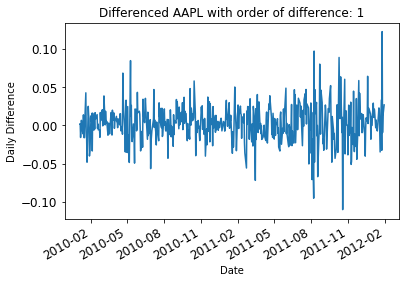

df head: 
 2010-01-04    0.001689
2010-01-05    0.001689
2010-01-06   -0.015908
2010-01-07   -0.001830
2010-01-08    0.006523
Name: AAPL, dtype: float64 

df tail: 
 2012-01-24   -0.032708
2012-01-25    0.122665
2012-01-26   -0.009479
2012-01-27    0.012389
2012-01-30    0.026748
Name: AAPL, dtype: float64 



In [200]:
# testing the turn_stationary function to differenced series and order of difference for the stock AAPL (Apple Corp.)

result = turn_stationary(prices_norm['AAPL'])
print('Asset: AAPL')
asset = result[1]
adf_df = adfuller(asset)
dfoutput = pd.Series(adf_df[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
for key,value in adf_df[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print(dfoutput, '\n')

title = 'Differenced AAPL with order of difference: ' + str(result[0])
ax = asset.plot(title=title, fontsize=12)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Difference')
plt.show()
print('df head: \n', asset.head(), '\n')
print('df tail: \n', asset.tail(), '\n')

In [177]:
# this cell print the order of difference for each column
stationary_assets = pd.DataFrame(index=dates)
stationary_assets.index.name = 'Date'

diff_orders = np.array([])
for sym in syms:
    tup = turn_stationary(prices_norm[sym])
    diff_order = tup[0]
    diff_orders = np.append(diff_orders,diff_order)

print(diff_orders)


[1. 1. 1. 1.]


In [189]:
# since each stationary series' order of difference is 1, I simply apply the 
# pd.diff() function to a copy of the original DataFrame prices_norm
stationary_df = prices_norm.copy()
stationary_df = stationary_df.diff()
stationary_df.fillna(method="ffill", inplace=True)
stationary_df.fillna(method="bfill", inplace=True)
print('df head: \n', stationary_df.head(), '\n')
print('df tail: \n', stationary_df.tail(), '\n')


df head: 
                 GOOG      AAPL       GLD       XOM
2010-01-04 -0.004404  0.001689 -0.000911  0.003873
2010-01-05 -0.004404  0.001689 -0.000911  0.003873
2010-01-06 -0.025098 -0.015908  0.016485  0.008675
2010-01-07 -0.022593 -0.001830 -0.006284 -0.003253
2010-01-08  0.012637  0.006523  0.005009 -0.004028 

df tail: 
                 GOOG      AAPL       GLD       XOM
2012-01-24 -0.007323 -0.032708 -0.010474 -0.004338
2012-01-25 -0.018253  0.122665  0.040164  0.000620
2012-01-26 -0.002218 -0.009479  0.007741 -0.006971
2012-01-27  0.018955  0.012389  0.015483 -0.014253
2012-01-30 -0.003654  0.026748 -0.008561 -0.005112 



Asset:  GOOG
test statistic          -22.974583
p-value                   0.000000
# of lags                 0.000000
# of observations       522.000000
Critical Value (1%)      -3.442940
Critical Value (5%)      -2.867093
Critical Value (10%)     -2.569727
dtype: float64 



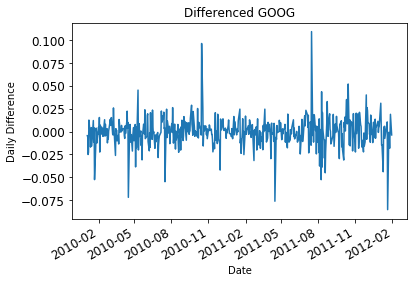

Asset:  AAPL
test statistic         -1.025711e+01
p-value                 4.332191e-18
# of lags               6.000000e+00
# of observations       5.160000e+02
Critical Value (1%)    -3.443087e+00
Critical Value (5%)    -2.867158e+00
Critical Value (10%)   -2.569762e+00
dtype: float64 



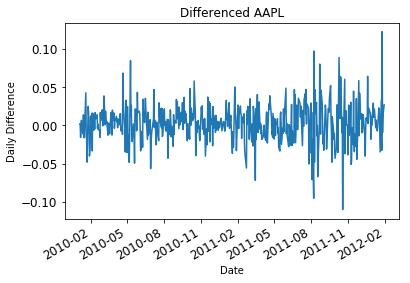

Asset:  GLD
test statistic          -23.617579
p-value                   0.000000
# of lags                 0.000000
# of observations       522.000000
Critical Value (1%)      -3.442940
Critical Value (5%)      -2.867093
Critical Value (10%)     -2.569727
dtype: float64 



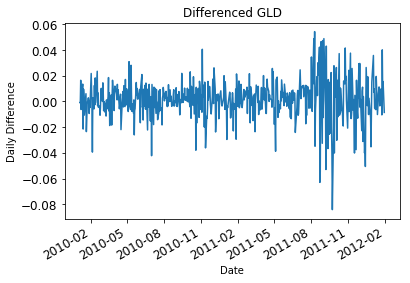

Asset:  XOM
test statistic         -8.209745e+00
p-value                 6.869501e-13
# of lags               7.000000e+00
# of observations       5.150000e+02
Critical Value (1%)    -3.443112e+00
Critical Value (5%)    -2.867168e+00
Critical Value (10%)   -2.569768e+00
dtype: float64 



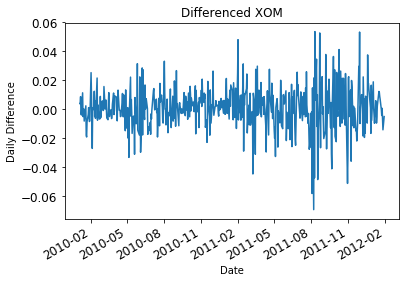

In [201]:
# performs an Augmented Dickey-Fuller test to determine if each column is a stationary time series or not.
# An Augmented Dickey-Fuller test tests a time series against the null hypothesis
# that there is a unit root contained in it.
# If the p_value is large (>0.05), it is likely that there is a unit root and thus the series is not stationary
# Otherwise, it is likely that the series is stationary   
# It will also plot the differenced series for each stock
for sym in syms:
    print('Asset: ', sym)
    diff = stationary_df[sym]
    adf_df = adfuller(diff)
    dfoutput = pd.Series(adf_df[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key,value in adf_df[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput, '\n')
    title = 'Differenced ' + str(sym)
    ax = diff.plot(title=title, fontsize=12)
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily Difference')
    plt.show()

# If you run this cell, you will see that the series in this portfolio are stationary time series
# since the p-values are much smaller than 0.05, note that all of the critical values are less than the test statistic

In [192]:
# the next few cells will focus on setting up an ARIMA model for each column in stationary_df for modelling purposes
# 
#from statsmodels.tsa.stattools import acf, pacf
#lag_acf = acf(, nlags=20)
#lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')
